In [1]:
import pandas as pd
import ipywidgets as widgets

import matplotlib as mpl
%matplotlib notebook
plt.ioff()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from geonamescache import GeonamesCache
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


In [2]:
import os
os.chdir('/Users/phumphreys/Repositories/personal_calcs/Energy storage')
datafile = 'IEA_HeadlineEnergyData_2017.xlsx'
xl = pd.ExcelFile(datafile)

In [3]:
gc = GeonamesCache()
countries =  gc.get_dataset_by_key(gc.get_countries(),'iso3')
country_iso3_list = countries.keys()

middle_eastern_countries = ['Bahrain', 'Iran', 'Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syria', 'United Arab Emirates', 'Yemen']
continent_code_to_IEA = {u'AF': 'Africa', u'NA': 'Non-OECD Americas', u'OC':'Non-OECD Asia (including China)', u'AS':'Non-OECD Asia (including China)', u'EU':'Non-OECD Europe and Eurasia', u'SA':'Non-OECD Americas'}

from incf.countryutils import transformations

def get_IEA_data_for_countries(database,country_code):
    failed = False
    try:
        country_name = transformations.cc_to_cn(country_code)
    
        continent_code = transformations.cca_to_ctca2(country_code)

        if country_name in database.index:
            value = database.ix[country_name]['color']
        elif country_name == 'China':
            value = database.ix["People's Republic of China"]['color']
        elif country_name == 'South Korea':
            value = database.ix["Korea"]['color']
        elif country_name == 'Slovakia':
            value = database.ix["Slovak Republic"]['color']
        elif country_name in middle_eastern_countries:
            value = database.ix['Middle East']['color']
        elif continent_code in continent_code_to_IEA:
            value = database.ix[continent_code_to_IEA[continent_code]]['color']
        else:

            value = '#dddddd'
    except:
        failed = True
        value = '#dddddd'
    return value, failed


def norm_cmap(values, cmap, vmin=None, vmax=None):
    """
    Normalize and set colormap
    
    Parameters
    ----------
    values : Series or array to be normalized
    cmap : matplotlib Colormap
    normalize : matplotlib.colors.Normalize
    cm : matplotlib.cm
    vmin : Minimum value of colormap. If None, uses min(values).
    vmax : Maximum value of colormap. If None, uses max(values).
    
    Returns
    -------
    n_cmap : mapping of normalized values to colormap (cmap)
    
    """
    mn = vmin or min(values)
    mx = vmax or max(values)
    norm = Normalize(vmin=mn, vmax=mx)
    n_cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return n_cmap


In [60]:
df1 = xl.parse('TimeSeries_1971-2016',skiprows=1)

product_selection = widgets.Dropdown(
    options=df1.Product.unique().tolist(),
    value='Total',
    description='Product:',
    disabled=False,
)

flow_selection = widgets.Dropdown(
    options=df1[df1.Product.isin([product_selection.value])].Flow.unique().tolist(),
    value='Electricity output (GWh)',
    description='Flow:',
    disabled=False,
)

year_selection = widgets.Dropdown(
    options=range(1971,2016),
    value=2015,
    description='Year:',
    disabled=False,
)

In [89]:
class display_data():
    def crunch_data(self):
        self.year = year_selection.value
        self.product_var = product_selection.value
        self.flow_var = flow_selection.value
        self.title = self.product_var + ' ' + self.flow_var + ' {}'.format(self.year)
        self.data = df1[np.logical_and(df1.Product.isin([self.product_var]),df1.Flow.isin([self.flow_var]))].filter(items=['Country',self.year])
        self.data.set_index('Country', inplace=True)

    def plot_chloropleth(self,reset = False):
        
        self.crunch_data()
        
        # Following http://ramiro.org/notebook/basemap-choropleth/

        cm = plt.get_cmap('Blues')
        cmap = norm_cmap(self.data[self.year].values.tolist(), cmap=cm)
        self.data = self.data.assign(color=[cmap.to_rgba(value) for value in self.data[self.year].values])

        country_colors = {}
        for iso3 in country_iso3_list:
            country_colors[iso3],failed =  get_IEA_data_for_countries(self.data,iso3)

        try: 
            self.mapfig
        except AttributeError:
            print 'Recalculating'
            reset = True

        if reset:

            self.mapfig = plt.figure(figsize=(8, 5));

            self.mapax = self.mapfig.add_subplot(111, frame_on=False);
            self.ax_legend = self.mapfig.add_axes([0.27, 0.1, 0.5, 0.03]);
            self.cols = []

            self.m = Basemap(lon_0=0, projection='robin',ax=self.mapax)
            self.m.readshapefile("ne_10m_admin_0_countries_lakes", 'units', color='#444444', linewidth=.2)

            self.country_patches = {}

            for info, shape in zip(self.m.units_info, self.m.units):
                iso3 = info['ADM0_A3']
                if iso3 in self.country_patches:
                    self.country_patches[iso3].append(Polygon(np.array(shape)))
                else: 
                    self.country_patches[iso3] =[Polygon(np.array(shape))]

        self.mapfig.suptitle(self.title, fontsize=15, y=.95)

        for col in self.cols:
            try:
                col.remove()
            except:
                pass
        for iso3, patches in self.country_patches.iteritems():
            pc = PatchCollection(patches)
            if iso3 in country_colors:
                pc.set_facecolor(country_colors[iso3])
            else:
                 pc.set_facecolor('#dddddd')
            self.cols.append(self.mapax.add_collection(pc))

        # Draw color legend.
        cmap.set_array([]) # can be an empty list
        self.cb = self.mapfig.colorbar(cmap, ax=self.mapax,cax=self.ax_legend, orientation='horizontal');
        self.cb.ax.tick_params(labelsize=10) 
        
        display(self.mapfig)

data_obj = display_data()

In [90]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
printmd("**Products**")
for name in df1.Product.unique(): print name 
printmd("**Flows**")
for name in df1.Flow.unique(): print name 

**Products**

Coal, peat and oil shale
Crude,NGL and feedstocks
Oil products
Natural gas
Nuclear
Renewables and waste
Electricity
Heat
Total
Fossil fuels
Renewable sources


**Flows**

Production (ktoe)
Imports (ktoe)
Exports (ktoe)
Total primary energy supply (ktoe)
Electricity plants (ktoe)
CHP plants (ktoe)
Heat plants (ktoe)
Oil refineries, transformation (ktoe)
Total final consumption (ktoe)
Industry (ktoe)
Transport (ktoe)
Other (ktoe)
of which: Residential (ktoe)
of which: Commerce and public services (ktoe)
Electricity output (GWh)
Total CO2 emissions - Fuel Combustion (Mt of CO2)


In [91]:
display(product_selection,flow_selection,year_selection)

Dropdown(description=u'Product:', index=8, options=(u'Coal, peat and oil shale', u'Crude,NGL and feedstocks', u'Oil products', u'Natural gas', u'Nuclear', u'Renewables and waste', u'Electricity', u'Heat', u'Total', u'Fossil fuels', u'Renewable sources'), value=u'Total')

Dropdown(description=u'Flow:', index=5, options=(u'Production (ktoe)', u'Imports (ktoe)', u'Exports (ktoe)', u'Total primary energy supply (ktoe)', u'Electricity plants (ktoe)', u'CHP plants (ktoe)', u'Heat plants (ktoe)', u'Oil refineries, transformation (ktoe)', u'Total final consumption (ktoe)', u'Industry (ktoe)', u'Transport (ktoe)', u'Other (ktoe)', u'of which: Residential (ktoe)', u'of which: Commerce and public services (ktoe)', u'Electricity output (GWh)', u'Total CO2 emissions - Fuel Combustion (Mt of CO2)'), value=u'CHP plants (ktoe)')

Dropdown(description=u'Year:', index=44, options=(1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015), value=2015)

<IPython.core.display.Javascript object>


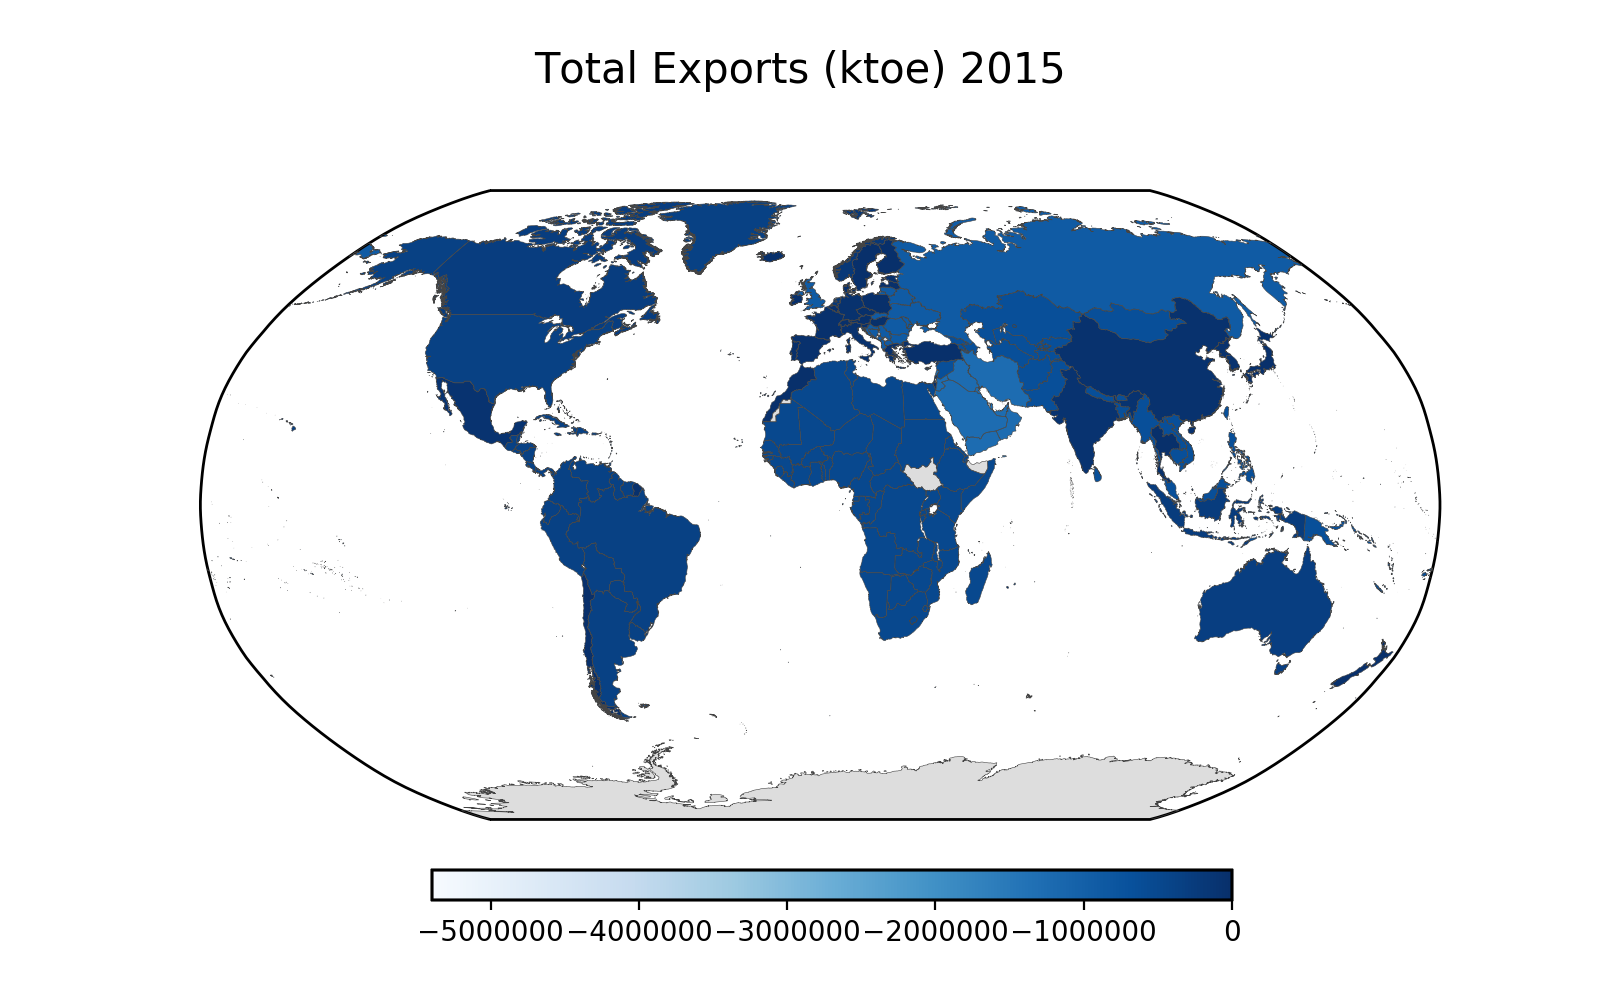

In [103]:
data_obj.plot_chloropleth()

In [104]:
data_obj.data

,2015,color
Country,,
Australia,-297887,"(0.0313725490196, 0.245074971165, 0.5040061514..."
Austria,-9303.63,"(0.0313725490196, 0.188235294118, 0.4196078431..."
Belgium,-30876.2,"(0.0313725490196, 0.19229527105, 0.42563629373..."
Canada,-284422,"(0.0313725490196, 0.241014994233, 0.4979777008..."
Chile,-1077.73,"(0.0313725490196, 0.188235294118, 0.4196078431..."
Czech Republic,-8371.23,"(0.0313725490196, 0.188235294118, 0.4196078431..."
Denmark,-16406.9,"(0.0313725490196, 0.188235294118, 0.4196078431..."
Estonia,-2048.25,"(0.0313725490196, 0.188235294118, 0.4196078431..."
Finland,-7483.5,"(0.0313725490196, 0.188235294118, 0.4196078431..."


In [105]:
import wbpy

api = wbpy.IndicatorAPI()

iso_country_codes = ["GB", "FR", "JP"]
total_population = "SP.POP.TOTL"

dataset = api.get_dataset(total_population, iso_country_codes, date="2015")
print dataset

{u'FR': {u'2015': 66624068.0},
 u'GB': {u'2015': 65128861.0},
 u'JP': {u'2015': 127141000.0}}
